In [1]:
# Install dependencies
import sys

!{sys.executable} -m pip install smdebug
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install bokeh
!{sys.executable} -m pip install imageio

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import boto3
import io
import sagemaker
import operator
from botocore.exceptions import WaiterError
from botocore.waiter import WaiterModel
from botocore.waiter import create_waiter_with_client

%matplotlib inline
import s3fs
import time
import random
import datetime
import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.style.use("ggplot")
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

import pickle, gzip, urllib, json
import csv

In [3]:


# Create custom waiter for the Redshift Data API to wait for finish execution of current SQL statement
waiter_name = 'DataAPIExecution'
#JSON
delay=2
max_attempts=3

#Configure the waiter settings
waiter_config = {
  'version': 2,
  'waiters': {
    'DataAPIExecution': {
      'operation': 'DescribeStatement',
      'delay': delay,
      'maxAttempts': max_attempts,
      'acceptors': [
        {
          "matcher": "path",
          "expected": "FINISHED",
          "argument": "Status",
          "state": "success"
        },
        {
          "matcher": "pathAny",
          "expected": ["PICKED","STARTED","SUBMITTED"],
          "argument": "Status",
          "state": "retry"
        },
        {
          "matcher": "pathAny",
          "expected": ["FAILED","ABORTED"],
          "argument": "Status",
          "state": "failure"
        }
      ],
    },
  },
}

In [4]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [5]:
sagemaker_session = sagemaker.Session()

In [7]:
#session = boto3.session.Session()
#region = session.region_name

# Creating the data api client
#bc_session = s.get_session()

#session = boto3.Session(
#        botocore_session=bc_session,
#        region_name=region
#    )

# Setup the client
client_redshift = boto3.client("redshift-data")
print("Data API client successfully loaded")

Data API client successfully loaded


Amazon SageMaker integrates seamlessly with Amazon S3. During the first step in creating the notebook, we specified a `AmazonSageMakerFullAccess` role for the notebook. That gives this notebook permission to access any Amazon S3 bucket in this AWS account with "sagemaker" in its name.

The get_execution_role function retrieves the IAM role you created at the time you created your notebook instance.

In [8]:
from sagemaker import get_execution_role

role = get_execution_role()

In [9]:
role

'arn:aws:iam::711415738051:role/TeamRole'

In [10]:
client_redshift.list_schemas(
        Database='workshopredshiftdb',
        ClusterIdentifier='wsredshiftcluster-aefuqdzmefci',
        DbUser='admin'
    )['Schemas']

['catalog_history',
 'information_schema',
 'pg_catalog',
 'pg_internal',
 'public']

In [11]:
client_redshift.list_tables(
        Database='workshopredshiftdb',
        ClusterIdentifier='wsredshiftcluster-aefuqdzmefci',
        DbUser='admin'
    )['Tables']

[{'name': 'sql_features',
  'schema': 'information_schema',
  'type': 'SYSTEM TABLE'},
 {'name': 'sql_implementation_info',
  'schema': 'information_schema',
  'type': 'SYSTEM TABLE'},
 {'name': 'sql_languages',
  'schema': 'information_schema',
  'type': 'SYSTEM TABLE'},
 {'name': 'sql_packages',
  'schema': 'information_schema',
  'type': 'SYSTEM TABLE'},
 {'name': 'sql_sizing',
  'schema': 'information_schema',
  'type': 'SYSTEM TABLE'},
 {'name': 'sql_sizing_profiles',
  'schema': 'information_schema',
  'type': 'SYSTEM TABLE'},
 {'name': 'padb_config_harvest',
  'schema': 'pg_catalog',
  'type': 'SYSTEM TABLE'},
 {'name': 'pg_aggregate', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_am', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_amop', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_amproc', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_attrdef', 'schema': 'pg_catalog', 'type': 'SYSTEM TABLE'},
 {'name': 'pg_att

#### Loading the dataset

In [27]:
qry_str = "unload('select recency,frequency,monetary from rfm_input_2') to 's3://teststack-2-wsdatasetbucket-1ebe4ih4r3hjn/rfm_output/rfm_' iam_role 'arn:aws:iam::711415738051:role/teststack-2-WSRedshiftIAMRole-69ZIJTVKYIR5' format as CSV parallel off"

In [28]:
waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

res = client_redshift.execute_statement(Database='workshopredshiftdb', DbUser='admin', Sql= qry_str, ClusterIdentifier='wsredshiftcluster-aefuqdzmefci')
id=res["Id"]

try:
    custom_waiter.wait(Id=id)
except WaiterError as e:
    print(e)

Waiter DataAPIExecution failed: Max attempts exceeded


In [29]:
s3_client = boto3.client("s3")
data_bucket_name = "teststack-2-wsdatasetbucket-1ebe4ih4r3hjn"

In [30]:
obj_list = s3_client.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)

['olist_customers_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_orders_dataset.csv', 'rfm_output/rfm_000']


In [31]:
file_data = file[3]

Grab the data from the CSV file in the bucket.

In [32]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
customers = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

This is what the first 5 rows of our data looks like:

In [33]:
customers.head()

,0.36360,0.0000,0.0390
0,0.36360,0.0000,0.0145
1,0.36360,0.0000,0.0315
2,0.36360,0.0000,0.0125
3,0.36360,0.0000,0.2055
4,0.40905,0.3125,0.0715


### d. Population segmentation using unsupervised clustering

Now, we’ll use the `KMeans` algorithm to segment by the RFM attributes we have created. `KMeans` is a clustering algorithm that identifies clusters of similar customers based on their attributes.

In [34]:
train_data = customers.values.astype("float32")

First, we call and define the hyperparameters of our `KMeans` model. The `KMeans` algorithm allows the user to specify how many clusters to identify. In this instance, let's try to find the top 5 clusters from our dataset.

In [35]:
from sagemaker import KMeans

num_clusters = 5
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + "teststack-2-wsdatasetbucket-1ebe4ih4r3hjn" + "/clustering_output/",
    k=num_clusters,
)

Then we train the model on our training data.

In [36]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-11-20 11:06:25 Starting - Starting the training job...
2021-11-20 11:06:52 Starting - Launching requested ML instancesProfilerReport-1637406385: InProgress
......
2021-11-20 11:07:52 Starting - Preparing the instances for training............
2021-11-20 11:09:54 Downloading - Downloading input data...
2021-11-20 11:10:16 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/20/2021 11:10:21 INFO 139648459515712] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_ena

Now we deploy the model, and we can pass in the original training set to get the labels for each entry. This will give us which cluster each county belongs to.

In [37]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!CPU times: user 154 ms, sys: 4.43 ms, total: 158 ms
Wall time: 5min 1s


In [38]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 4.28 s, sys: 81.5 ms, total: 4.36 s
Wall time: 6.88 s


We can see the breakdown of cluster counts and the distribution of clusters.

In [39]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [40]:
pd.DataFrame(cluster_labels)[0].value_counts()

2.0    26224
4.0    22397
0.0    20381
1.0    15692
3.0    11400
Name: 0, dtype: int64

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


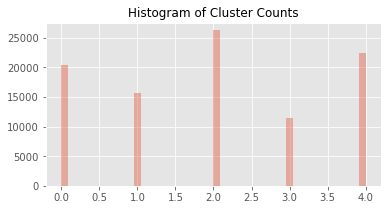

In [41]:
ax = plt.subplots(figsize=(6, 3))
ax = sns.distplot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

However, to improve `explainability`, we need to access the underlying model to get the cluster centers. These centers will help describe which features characterize each cluster.

## Step 4: Drawing conclusions from our modelling

Explaining the result of the modelling is an important step in making use of our analysis. The information contained in the model attributes within an Amazon SageMaker trained model, we can form concrete conclusions based on the data.

### a. Accessing the KMeans model attributes - ***WIP***

First, we will go into the bucket where the `KMeans` model is stored and extract it.

In [44]:
job_name = kmeans.latest_training_job.name
model_key = "clustering_output/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(data_bucket_name).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

In [45]:
Kmeans_model_params = mx.ndarray.load("model_algo-1")

**There is 1 set of model parameters that is contained within the KMeans model.**

**Cluster Centroid Locations**: The location of the centers of each cluster identified by the `KMeans` algorithm. The cluster location is given in our `PCA` transformed space with 5 components, since we passed the transformed `PCA` data into the model.

In [46]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = customers.columns

In [47]:
cluster_centroids

,0.36360,0.0000,0.0390
0,0.634398,0.017011,0.055366
1,2.828810,0.008801,0.058741
2,1.330940,0.007499,0.060912
3,3.650276,0.006419,0.056303
4,2.064080,0.008906,0.056788


We can plot a heatmap of the centroids and their location in the transformed feature space. This gives us insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA plus clustering techniques together. Since we were able to examine the makeup of each PCA component, we can understand what each centroid represents in terms of the `PCA` components that we interpreted previously.

For example, we can see that cluster 1 has the highest value in the "Construction & Commuters" attribute while it has the lowest value in the "Self Employment/Public Workers" attribute compared with other clusters. Similarly, cluster 4 has high values in "Construction & Commuters," "High Income/Professional & Office Workers," and "Self Employment/Public Workers."

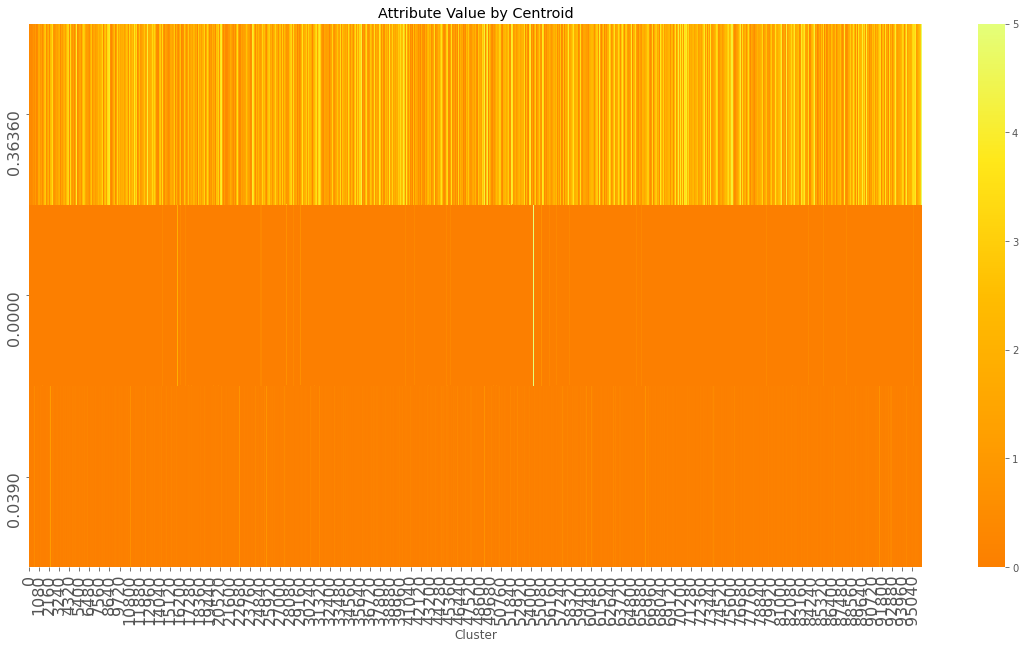

In [52]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(customers.T, cmap="Wistia_r")
ax.set_xlabel("Cluster")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_title("Attribute Value by Centroid")
plt.show()

###### Because endpoints are persistent, let’s delete our endpoints now that we’re done to avoid any excess charges on our AWS bill.

In [ ]:
pca_predictor.delete_endpoint()

In [ ]:
kmeans_predictor.delete_endpoint()